# Table of Contents
 <p>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import morgan as morgan
import genpy
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
genvar = gvars.genvars()

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# Specify which genotypes are double mutants 
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)


In [6]:
thomas.filter_data(0, 0.01)

In [7]:
barbara = morgan.mcclintock('bayesian', thomas, True)


starting comparison of d, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of d, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of d, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of d, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of b, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
starting comparison of b, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

In [8]:
def tidy_df(df, corr='corr', morgan_obj=thomas):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - a string indicating whether to use 'corr' or 'outliers'
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable',
        'fraction' and 'pair'
    """
    # make a copy of the df
    df = df.copy()
    # append a column called corr_with
    if 'corr_with' not in df:
        df['corr_with'] = morgan_obj.single_mutants
    # melt it so that each row has a single correlation
    df = pd.melt(df, id_vars='corr_with')
    # drop any observations where the correlated letters are the same
    df = df[df.corr_with != df.variable]

    def calculate_fraction(x, fraction='corr'):
        """Fraction of genes that participate in a given interaction."""
        if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
            dd = barbara.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan
    
    # calculate the fraction of genes participating in any interaction 
    df['fraction'] = df.apply(calculate_fraction, args=(corr,), axis=1)
    # generate a new variable 'pair' that is 
    df['pair'] =  df.variable + df.corr_with
    # return the damned thing:
    return df


In [9]:
def different(x, d):
    """
    Returns an indicator variable if the primary regression
    is different in sign from the secondary.
    """
    # extract the pair in question:
    p = x.pair
    # search for the primary interaction in the dataframe
    primary = d[(d.pair == p) & 
                (d.regression == 'primary')].value.values[0]
    # search for the secondary
    secondary = d[(d.pair == p) & 
                  (d.regression == 'secondary')].value.values[0]
    
    # if the interactions are 0, return 0
    if primary == 0 or secondary == 0:
        return 0
    # if they have the same sign, return -1
    elif (primary*secondary > 0):
        return -1
    # otherwise return 1
    else:
        return 1

In [10]:
def special_add(x):
    """
    If the primary and secondary have the same sign,
    returns the addition of both.
    """
    # if the current row is a secondary row
    # and the primary and secondary rows are the same
    # then return np.nan since we will want to ignore 
    # the secondary correlation
    # if they are different in sign, return the current value
    if x.regression == 'secondary':
        if x.different == -1:
            return np.nan
        else:
            return x.value
    
    # if the regression is primary, 
    # then add the values if the correlations have the same sign
    # otherwise just return the current value:
    check = d[(d.regression=='secondary') & \
         (d.pair == x.pair)].different.values
    if check == -1:
        to_add = d[(d.regression=='secondary') & 
                   (d.pair == x.pair)].value.values[0]
        return x.value + to_add
    else:
        return x.value

In [11]:
# tidy up the dataframe w/bayesian primary interactions:
d_pos = tidy_df(barbara.robust_slope)
# add a label specifying these are the primary regressions
d_pos['regression'] = 'primary'
# tidy up the secondary interactions
d_minus = tidy_df(barbara.secondary_slope, corr='outliers')
# add a label specifying these are the secondary regressions
d_minus['regression'] = 'secondary'

# concatenate the dataframes
frames = [d_pos, d_minus]
d = pd.concat(frames)

# identify whether primary and secondary 
# interactions have different signs
d['different'] = d.apply(different, args=(d,), axis=1)
# drop any fractions that are NAN
d.dropna(subset=['fraction'], inplace=True)
# calculate corrected coefficients
d['corrected'] = d.apply(special_add, axis=1)
# drop any NAN corrected columns
d.dropna(subset=['corrected'], inplace=True)

# sort the pairs according to functional distance
d['sort_pairs'] = d.pair.map(genvar.sort_pairs)
d.sort('sort_pairs', inplace=True)

# add the labels for plotting:
d['genes'] = d.pair.map(genvar.decode_pairs)

In [12]:
# extract the standard error for each correlation
e_plus = tidy_df(barbara.errors_primary)

# add a sort pairs column
e_plus['sort_pairs'] = e_plus.pair.map(genvar.sort_pairs)
# decode the gene pairs
e_plus['genes'] = e_plus.pair.map(genvar.decode_pairs)
# sort
e_plus.sort('sort_pairs', inplace=True)
# drop nonnumeric values
e_plus.dropna(inplace=True)

# repeat for secondary errors
e_minus = tidy_df(barbara.errors_secondary)
e_minus['sort_pairs'] = e_minus.pair.map(genvar.sort_pairs)
e_minus['genes'] = e_minus.pair.map(genvar.decode_pairs)
e_minus.sort('sort_pairs', inplace=True)
e_minus.dropna(inplace=True)

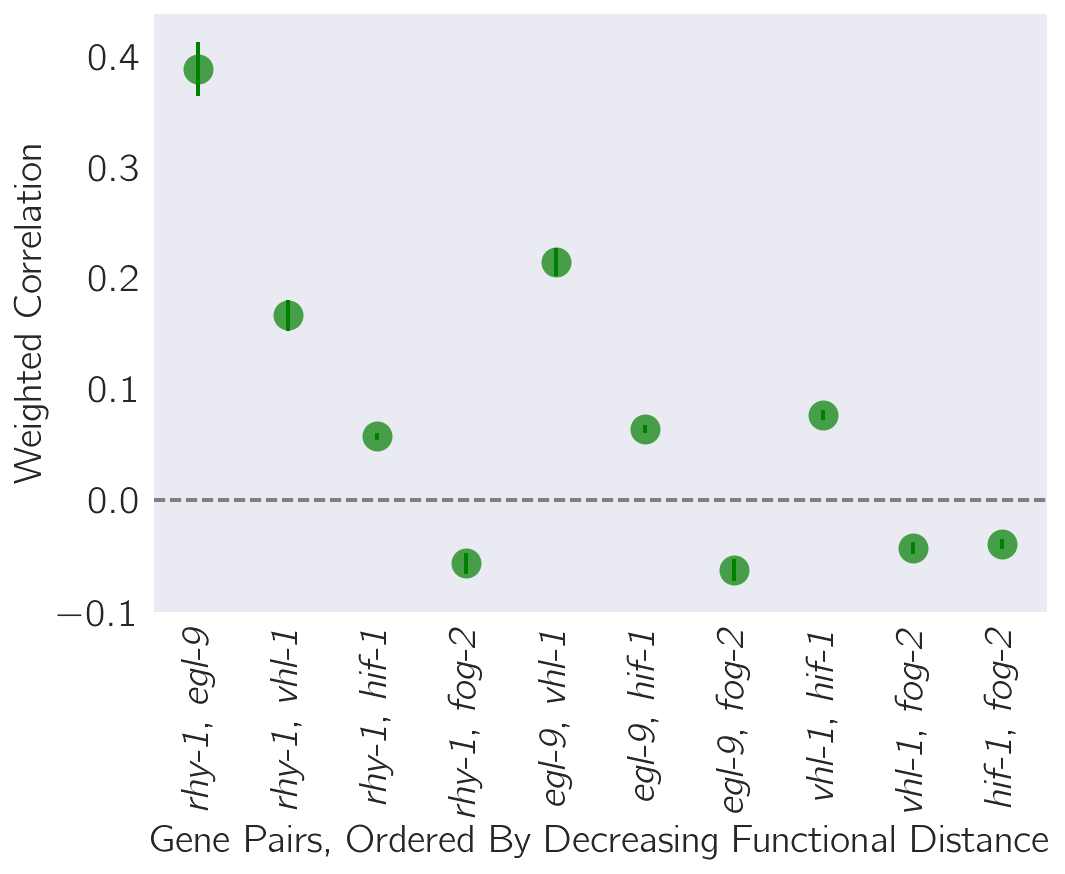

In [16]:
# generate a stripplot with all the 
sns.stripplot(x='genes', y='corrected',
              data=d[d.regression=='primary'], size=15,
              color='g', alpha=0.7)

# add errorbars:
# for each xtick and xticklabel
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    # get the data
    temp = d[d.regression=='primary']
    # get the gene ID
    f = temp.genes == xlabel.get_text() 
    # get the error bar gene ID
    f2 = e_plus.genes == xlabel.get_text() 
    # plot the errorbar
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_plus[f2].value.values,
                       ls='none', color='g')

# prettify:
plt.xticks(rotation=90, fontsize=20)
# plt.yticks([-0.1, 0, 0.5], fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Gene Pairs, Ordered By Decreasing Functional Distance', fontsize=20)
plt.ylabel('Weighted Correlation', fontsize=20)

# # pathify
# pathify('Weighted Correlations Reflect Functional Distance',
#         'Pairs of Genes, Ordered by Decreasing Functional Distance',
#        'Primary Correlation, Normalized to Overlap')

# save
plt.savefig('../output/weighted_corr_decreases_w_distance.svg')

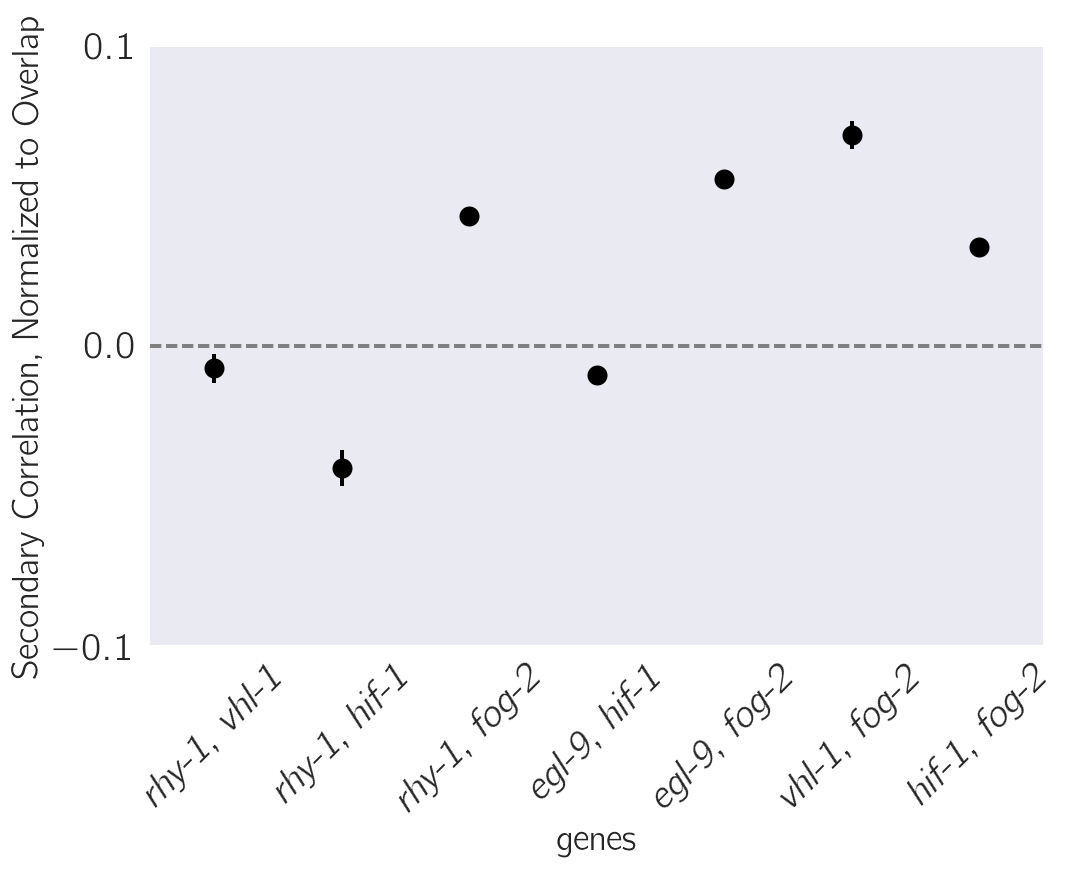

In [14]:
# plot secondary interactions
sns.stripplot(x='genes', y='corrected', 
              data=d[(d.regression=='secondary') &
                     (d.different == 1)],
              size=10, color='k')

# add errorbars:
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    temp = d[d.regression=='secondary']
    f = temp.genes == xlabel.get_text() 
    f2 = e_minus.genes == xlabel.get_text() 
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_minus[f2].value.values,
                       ls='none', color='k')

# prettify
plt.axhline(0, ls='--', color='0.5')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.ylabel('Secondary Correlation, Normalized to Overlap')